# Introduction

Please install the required packages if you are using jupyter notebook.

`conda create --name <your_new_env> --file requirements.txt`

or

`conda install --name <your_existing_env> --file requirements.txt`

In [1]:
# For google colab users, uncomment the following line to get these packages (not installed by default)
!pip install contractions
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00


In [2]:
import torch
import pandas as pd
import random
from io import open
import glob
import os
import time
import torch.nn as nn
import nltk
import re
import contractions
import gensim.downloader as api
import matplotlib.pyplot as plt

from datasets import load_dataset
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from torch.utils.data import DataLoader

In [3]:
nltk.download('stopwords')

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


device(type='cpu')

# Getting Data

In [4]:
# Load our data
ds = load_dataset("stanfordnlp/imdb")

# Get text from all the splits
contents = []
for split in ds.keys():
    for review in ds[split]:
        contents.append(review['text'])
all_text = ' '.join(contents)
all_text[:150]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard th'

# Cleaning Text

Now, cleaning your data is a must in essentially any task. Why? Look at this raw text.


In [5]:
raw_text = all_text[:500]
raw_text

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent'

## What do you notice?

Some text -- expected ...

Some html tags -- ermm..

This is only one review. We should expect that there will be typos, inconsistencies and a bunch of other problems in the rest of the reviews that we will use to train our embedding model.

Garbage in, garbage out.

I suggest cleaning them! 🧹

## What should you do?
Typically, data cleaning consists of several steps, including:

1. Standardizing
3. Tokenizing
4. Indexing
5. Encoding

There isn't a clear rules that you must follow for every NLP projects. Each problem requires a different cleaning techniques, and most of the time it is up to the person in charge. Think of this like an experimental loop where you would try several techniques, observe the results, evaluate and re-iterate.

In every step of the cleaning process, it is important to keep the downstream task in mind. Here, we are training a word embedding algorithm (more about it later), which doesn't require a lot of special cleaning techniques. They should be of standard format, but nothing fancy.

In short, to clean this text up, we will:

1. Transform to lowercase
3. Remove punctiations
4. Remove html tags
5. Expand contractions ("that's" to "that is")
6. Tokenize (split on white spaces)

**Note on 4**: notice that library functions arent't always producing the correct output, as in almost everything in NLP. Example: "I'd" can be expanded to "I would" or "I had".

### Quiz ദ്ദി ˉ͈̀꒳ˉ͈́ )✧: Do you always normalize to lowercase for ANY NLP task?

-- TODO: Put your answer here --ANSWER: NOT REQUIRED. BASED ON USE CASE WE CAN PERFORM PREPROCESSING TECHNIQUE LIKE CONVERTING TO LOWER CASE.

## Standardizing

In [6]:
def remove_html_tags(text):
    cleaned = re.sub(r'<.+?>', '', text)
    return cleaned

def remove_punctuations(text):
    cleaned = re.sub(r"[^'\w\d\s]", ' ', text)
    return cleaned

def clean_text(text):
    cleaned = remove_punctuations(remove_html_tags(contractions.fix(text)))
    return cleaned.lower()

cleaned_text = clean_text(all_text)

In [7]:
cleaned_text[:100] # Your RAM begs you to not see everything

'i rented i am curious yellow from my video store because of all the controversy that surrounded it w'

In [8]:
print(f'The corpus contains {len(cleaned_text)} words')

The corpus contains 129928066 words


That sounds like a lot of words. For the purpose of our assignment, we should reduce this number. The choice to train with 100 words, 1K, 1M, 10M or more words is up to you. So, experiment with this number and see it out for yourself.

In [9]:
# Keep only 1 million words
limit = 1*(10**6)
cleaned_text = cleaned_text[:limit]

## Tokenizing

### Quiz ദ്ദി ˉ͈̀꒳ˉ͈́ )✧: Which word below do you think appears the most in the corpus (without looking them up)?

a. the

b. unflinching

c. david


-- TODO: Put your answer here (HINT: What is a stopword?) --
ANSWER: OPTION A.the

In [10]:
# Tokenize the text -- fancy word for just splitting by white spaces.
tokens = cleaned_text.split()

# Remove stopwords
# For faster look up
english_stopwords_set = set(stopwords.words('english'))

# Choose non-stopwords only, and keep the relative position
tokens = [token for token in tokens if token not in english_stopwords_set]
tokens = list(dict.fromkeys(tokens))

tokens[:10]

['rented',
 'curious',
 'yellow',
 'video',
 'store',
 'controversy',
 'surrounded',
 'first',
 'released',
 '1967']

## Indexing

Here, we are just mapping the vocabulary to their index.

In [11]:
vocab = {}
indices = {}
index = 0
for i, token in enumerate(tokens):
    if token not in vocab:
        vocab[token] = i
    if token not in indices:
        indices[i] = token
len(vocab.keys())

14546

**NOTE**: Almost every stage of the above cleaning procedure has its downside and can be improved. The task is quite open-ended, so don't let your fear stop you from experimenting.

## Did you notice something funny?

In case you haven't noticed, I have collapsed every reviews into a giant reviews. I guess this is also a good time to introduce the elephant in the room:

        Word2Vec with Skip Grams and Negative Sampling

That sounds like a lot, doesn't it? In reality, it is just:

![alt text](https://drive.google.com/uc?id=1TpWSBSX4gXv6kyEfO3u0QLIwQ-aw3fns)

To highlight, here are some design choices that we have made in cleaning our text:

1. By collapsing the reviews together, we are saying that the last word of the current review will be positive examples for the first word of the next review. Doesn't sound right, does it? Though for simplicity sake, it suits our purpose.
2. Alternatively, we could work on individual review to solve the above problem. Now that introduces the other problem. Suppose the first review has 200 words -- the pool in which we will choose our negative examples from will have (roughly) 200 words. Cool? Now let's suppose that the next review has another 200 words, but now we have (roughly) 400 words in the pool to choose from: 200 currently, and 200 previously. See the problem? Not a bad design choice at all, but the point is that in pursuing something, you gotta give up something else. (ᵕ—ᴗ—)

There are no bad ideas as long as you can back them up.

**Note**: this is a simplified version of Word2Vec -- actual implementation is more complicated.

# Word2vec Details

##  Generate positive and negative examples

For each word, we do the following:
1. Pick the target word
2. Choose the surrounding words as positive examples
3. Randomly choose other words as negative examples

In [12]:
def positive_samples(index: int, window_size: int) -> list[tuple[str, str]]:
    """Generate positive samples from the left and right size of the current word.

    Args:
        index: index of the current/target word.
        window_size: the size toward left/right to grab positive context words.

    Returns
        A list of tuples, where tuples[0] is the target word and tuples[1] is the positive context word.
    """
    target_word = tokens[index]

    # keep the index inbound
    left_index = max(0, index - window_size)
    right_index = min(len(tokens) - 1, index + window_size)

    positives = []
    # left side of the target word
    for i in range(left_index, index):
        positives.append((target_word, tokens[i]))

    # right side of the target word
    for i in range(index+1, right_index+1):
        positives.append((target_word, tokens[i]))

    return positives



In [13]:
# grab positive samples from within 3-range of the current target word, index=5, window_size=3
positive_samples(5, 3)

[('controversy', 'yellow'),
 ('controversy', 'video'),
 ('controversy', 'store'),
 ('controversy', 'surrounded'),
 ('controversy', 'first'),
 ('controversy', 'released')]

For each of the positive samples above, we would need to choose `k` negative samples, and we would need more negative samples than we need positive.

## Generate training batches

The below implementation randomly pick negative samples from the list of possible words. In practice, people often choose negative samples based on their unigram frequency.

In other word, we need to calculate the frequency of all the unigram (just fancy name for a word) in the corpus, normalize that into weights (such that they sum to 1), pass them into `random.choices(weights=calulated_weight)` to sample negative samples.

We are not doing that here to keep the exercise light.

In [14]:
# Set number of negative samples and positive window size
negative_samples = 10
window_size = 3
def get_batch(batch_size: int, window_size: int, num_neg_samples: int) -> tuple[list[list[int]], list[list[int]], list[list[int]]]:
    """
    Split the data into context negative/positive and target batches.
    Length of negative context is `num_neg_samples` times larger than positive/target batches.
    Each batch consists of the index of the words.

    Args:
        batch_size: size of one batch
        window_size: number of positive samples to pick
        num_neg_samples: number of negative samples to pick

    Returns:
        context_positive_batch: A list of batches where the elements are context positive words
        context_negative_batch: A list of batches where the elements are context negative words
        target_batch:           A list of batches where the elements are target words
    """
    # total tokens = total_batches * batch_size
    total_batches = len(tokens) // batch_size

    # the last batch could be less than batch_size
    last_batch_size = len(tokens) - (total_batches * batch_size)
    print(f"We have {len(tokens)} tokens. Dividing into batches...")
    print(f"For {total_batches} batches, each of size {batch_size}, we accumulate a total of {batch_size * total_batches} tokens.")
    print(f"Leftover of {last_batch_size} tokens")

    # Put all batches in a list to loop through
    batch_sizes = [batch_size] * (total_batches)
    batch_sizes.append(last_batch_size)

    # Some cautious checks („• ֊ •„)੭
    assert last_batch_size < batch_size
    assert sum(batch_sizes) == len(tokens)

    # Batches to return
    context_negative_batch, context_positive_batch, target_batch = [], [], []
    word_index = 0

    for bsz in batch_sizes:
        # Initiate minibatches and fill them
        # pair 1 (positive, target) with k (negative, target)
        current_targets, current_pos_contexts, current_neg_contexts = [], [], []
        for i in range(bsz):
            target_word = tokens[word_index]

            # Get positive, negative examples and add them to the according list
            positive_words = [pair[1] for pair in positive_samples(word_index, window_size)]

            for word in positive_words:
                current_targets.append(vocab[target_word])
                current_pos_contexts.append(vocab[word])

                # Random sampling TODO (OPTIONAL): Unigram Frequency
                negative_words = random.choices(tokens, k=num_neg_samples)
                for word in negative_words:
                    current_neg_contexts.append(vocab[word])

            word_index += 1

        context_negative_batch.append(current_neg_contexts)
        context_positive_batch.append(current_pos_contexts)
        target_batch.append(current_targets)

    return context_positive_batch, context_negative_batch, target_batch

context_positive_batch, context_negative_batch, target_batch = get_batch(512, window_size=window_size, num_neg_samples=negative_samples)

We have 14546 tokens. Dividing into batches...
For 28 batches, each of size 512, we accumulate a total of 14336 tokens.
Leftover of 210 tokens


In [15]:
print(f'Number of positive context words {len(context_positive_batch[1])}')
print(f'Number of target words {len(target_batch[1])}')
print(f'Number of negative context words {len(context_negative_batch[1])}')

print(f"For each target/positive pairs, we have {negative_samples} pairs of negative examples")

Number of positive context words 3072
Number of target words 3072
Number of negative context words 30720
For each target/positive pairs, we have 10 pairs of negative examples


### Why the above numbers?

\#theydidthemath 🤓☝️

Assuming window size of 3, number of negative samples per pair is 10.

Window size of 3 --> 6 positive examples per word

512 * 6 = 3072

10 negative examples per pair

512 * 6 * 10 = 30720

Of course, the first and last batch has different size due to target words on edge have less positive samples.

## The model

**A quick note on embedding layers**

You can think of embedding layer as a look up table that map from our inputs (list of tokens) to our embeddings. How does it work?

To take the classic example of housing prices prediction in machine learning, the model learns to shift weights of features (like size, # of bedrooms, ...) in the direction that minimizes loss on the training instances. We are **mapping** from the inputs to the target **price**.

That's more or less how embedding layers work. We are trying (through training) to find ways to map from our large vocabulary size to our embedding size.

In [16]:
class EmbeddingModel(nn.Module):
    """An embedding model inheriting torch.Module.
    """
    def __init__(self, input_size: int, output_size: int):
        """Initilizes embedding model and its embedding weights.

        Args:
            input_size: size of the input
            output_size: size of the embedding
        """
        super(EmbeddingModel, self).__init__()
        self.target_embedding = nn.Embedding(input_size, output_size)
        self.context_embedding = nn.Embedding(input_size, output_size)

        # Intialize the weights
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.context_embedding.weight)


    def forward(self, positive_context: torch.Tensor, negative_context: torch.Tensor, target: torch.Tensor):
        """Lookup and return the embedding vector based on input indices.

        Args:
            positive_context: A tensor consisting of indexes of positive context words.
            negative_context: A tensor consisting of indexes of negative context words.
            target: A tensor consisting of indexes of target words.

        Returns:
            positive_tensor: A tensor output from context embedding layer.
            negative_tensor: A tensor output from context embedding layer.
            target_tensor: A tensor output from target embedding layer
        """
        negative_tensor = self.context_embedding(negative_context)
        positive_tensor = self.context_embedding(positive_context)
        target_tensor = self.target_embedding(target)

        return positive_tensor, negative_tensor, target_tensor

Note that negative and positive context from the `context_embedding` layer, while the target comes from `target_embedding`

### Trivia ദ്ദി ˉ͈̀꒳ˉ͈́ )✧: Which embedding layer will become our embedding vectors?

a. target_embedding

b. context_embedding

-- TODO: Put your answer here --
ANSWER: a. target_embeddings.

## The Loss

Here's the loss function that we need to use for our model and training data.

![alt text](https://drive.google.com/uc?id=1AcwDdhU1inKLFF_I6caegYp98UJO56O8 "CustomLoss")

In [17]:
class SkipGNGLoss(nn.Module):
    """A custom loss used for training word2vec with skipgram and negative sampling.
    """
    def __init__(self):
        """Initializes loss module.
        """
        super(SkipGNGLoss, self).__init__()

    def forward(self, positive_context: torch.Tensor, negative_context: torch.Tensor, target_context: torch.Tensor):
        """Calculate loss of the given contexts/targets

        Args:
            positive_context: A tensor that is the output of context embedding layers.
            negative_context: A tensor that is the output of context embedding layers.
            target_context:   A tensor that is the output of target embedding layers.

        Returns:
            the average loss of the contexts/targets.
        """
        # do some tensor manipulation for loss calculation
        batch_dim, embedding_dim = target_context.shape
        positive_context = positive_context.view(batch_dim, 1, embedding_dim)
        target_context = target_context.view(batch_dim, embedding_dim, 1)

        negative_context = -1 * negative_context.view(batch_dim, negative_samples, embedding_dim)

        # positive loss
        pos_loss = torch.log(torch.sigmoid(torch.matmul(positive_context, target_context))).squeeze()

        # negative loss
        neg_loss = torch.log(torch.sigmoid(torch.matmul(negative_context, target_context))).squeeze().sum(1)

        return -(pos_loss + neg_loss).mean()

**Note** To fully grasp the idea behind everything, refer to the textbook (chapter 6, section 8). Below is just a rough summary.

**Key Ideas**

1. How do we know if two vectors are similar? Dot product.
2. Sigmoid transform dot product into probabilty.
3. There are two events in our model (`context_word` being negative and `context_word` being positive).
  
   `P(positive | word, context)` = `sigmoid(context **dot** word)`

    `P(negative | word, context)` = `1 - P(positive | word, context)` = `sigmoid(-context **dot** word)`
6. We have many negative words, so we need to multiply their probabilities together (assume independence)
7. Using log helps with training, and instead of multiplying their probabilities we can just sum them up instead.

If textbook is your nemesis, look at the below summary

![alt text](https://drive.google.com/uc?id=1-07W8xw0DxGgTZXB2u-ql30-k4DZqzM_ "Summary")

## Training Loop

In [23]:
def train(classifier: torch.nn.Module, window_size: int = 3, num_neg_samples: int = 5,
          n_epoch: int = 10, batch_size: int = 512,
          report_every: int = 1000, learning_rate: int = 0.02) -> list[int]:
    """Define the training loop.

    Args:
        classifier: the embedding layer to train.
        window_size: the number of positive samples to pick.
        num_neg_samples: the number of negative smaples to pick per positive sample.
        n_epoch: the number of epochs to train for.
        batch_size: the size of individual batch.
        report_every: prints to the screen current loss after this many iterations.
        learning_rate: rate of which the learning is happening.

    Returns:
        A list of losses over the last epochs.
    """
    all_losses = []
    classifier.train()

    context_positive_batch, context_negative_batch, target_batch = get_batch(window_size=window_size, batch_size=batch_size, num_neg_samples=num_neg_samples)
    loss_fn = SkipGNGLoss()

    optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
    for iter in range(0, n_epoch):
        running_loss = 0
        for i in range(len(context_positive_batch)):
            optimizer.zero_grad()


            mini_positive_tensor = torch.tensor(context_positive_batch[i])
            mini_negative_tensor = torch.tensor(context_negative_batch[i])
            mini_target_tensor = torch.tensor(target_batch[i])

            positive_tensor, negative_tensor, target_tensor = classifier(mini_positive_tensor, mini_negative_tensor, mini_target_tensor)

            loss = loss_fn(positive_tensor, negative_tensor, target_tensor)
            loss.backward()
            nn.utils.clip_grad_norm_(classifier.parameters(), 1) #

            optimizer.step()

            running_loss += loss.item()

            if i % report_every == 0:
                print(f'Current loss is {running_loss}')
        all_losses.append(running_loss / len(tokens))

    print(f'Epoch {iter}, Loss: {all_losses[-1]}')

    return all_losses

## How to evaluate the embedding?

It is best to evaluate the effectiveness of a given embedding on downstream tasks. However, given the simplicity of our training and dataset, it would be more interesting to see the vectors move in meaningful way as a result of training. We will be visualizing the trained embedding vectors through t-SNE.

It is worth noting that that this might not be the best way to visualize word embeddings. We have an intuition of how the vectors should move, but we can't guarantee it, as is everything else in machine learning and deep learning.

##  Train word embedding

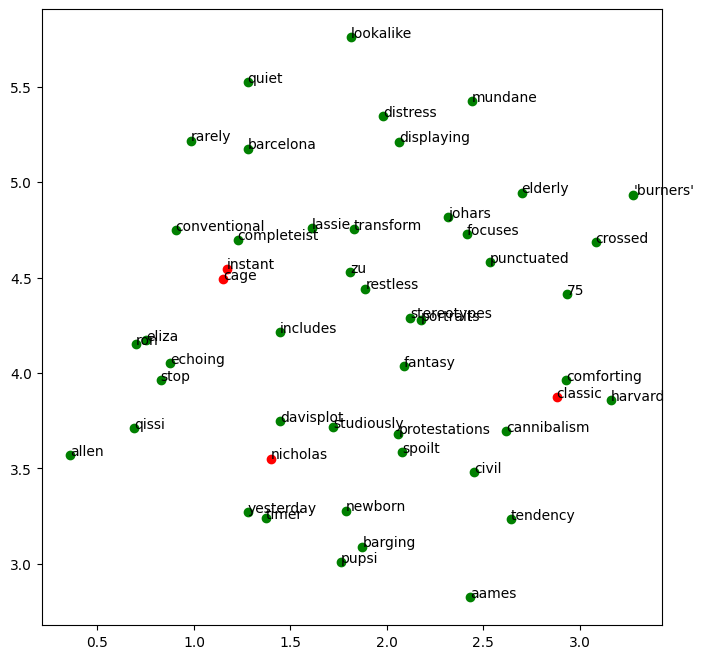

In [24]:
# Define embedding model
embedding_model = EmbeddingModel(len(tokens), 300)
embeddings = embedding_model.target_embedding.weight.to('cpu').data.numpy()

# Reduce the dimension and graph the initial vectors
# choose somewords -- we expect that instant will be closer to classic
# and nicholas to get closer to cage
# which isn't guaranteed, by the way, but it's just something to look for
random_words = random.choices(tokens, k=45)
special_words = ['instant', 'classic', 'nicholas', 'cage']
random_words.extend(special_words)
rw_indices = [vocab[word] for word in random_words]

# Intialize tsne
tsne = TSNE()
tsne_embedding = tsne.fit_transform(embeddings[rw_indices])

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(random_words)):
    if random_words[i] in special_words:
        plt.scatter(tsne_embedding[i, 0], tsne_embedding[i, 1], color='red')
    else:
        plt.scatter(tsne_embedding[i, 0], tsne_embedding[i, 1], color='green')
    plt.annotate(random_words[i], (tsne_embedding[i, 0], tsne_embedding[i, 1]))

In [ ]:

# Parameters used in training, feel free to switch them up
negative_samples = 10
window_size = 3
train(embedding_model, n_epoch=5, batch_size=2048, report_every=1000, learning_rate=0.0001, num_neg_samples=negative_samples)

"""
# Parameters used in training, feel free to switch them up
negative_samples = 10
window_size = 3
train(embedding_model, n_epoch=5, batch_size=2048, report_every=1000, learning_rate=10, num_neg_samples=negative_samples)

"""








We have 14546 tokens. Dividing into batches...
For 7 batches, each of size 2048, we accumulate a total of 14336 tokens.
Leftover of 210 tokens
Current loss is 7.624612808227539
Current loss is 7.624612808227539
Current loss is 7.624612808227539
Current loss is 7.624612808227539
Current loss is 7.624612808227539
Epoch 4, Loss: 0.0041933878569889475


'\n# Parameters used in training, feel free to switch them up\nnegative_samples = 10\nwindow_size = 3\ntrain(embedding_model, n_epoch=5, batch_size=2048, report_every=1000, learning_rate=10, num_neg_samples=negative_samples)\n\n'

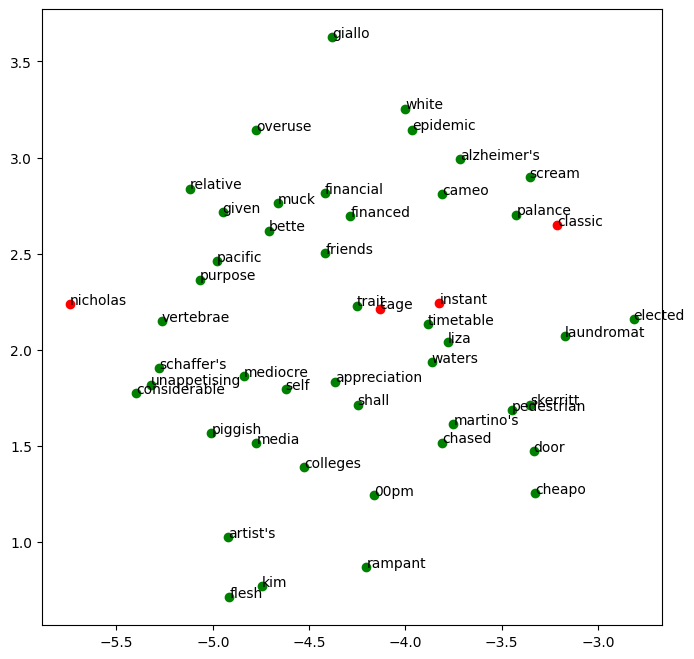

In [ ]:
# Get the embeddings
embeddings = embedding_model.target_embedding.weight.to('cpu').data.numpy()

# Graph the trained embedding again
tsne = TSNE()
tsne_embedding = tsne.fit_transform(embeddings[rw_indices])

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(random_words)):
    if random_words[i] in special_words:
        plt.scatter(tsne_embedding[i, 0], tsne_embedding[i, 1], color='red')
    else:
        plt.scatter(tsne_embedding[i, 0], tsne_embedding[i, 1], color='green')
    plt.annotate(random_words[i], (tsne_embedding[i, 0], tsne_embedding[i, 1]))

**NOTE**: Sometimes the result isn't consistent and/or very clear. With better training data, better techniques, better hardware  we would have better result (ideally). Given our setup, it isn't expected that the visualization above will be very clear.

The point here is that we are seeing the embedding moving with training. Sometimes the way they move doesn't necessarily align with our intuition, and that's okay. It's just deep learning at work!

# Examine

While loss during training is a great indicator to know if you're heading in the right direction, it isn't the only factor. For NLP task, downstream performance is important as well.

To examine the performance of word embedding algorithms, we can simply use our language knowledge. For example, 'man' is different from 'woman', and 'angry' is different from 'happy'. Does our embedding model capture this well?

One way to find out is using cosine similarity. Note:
- Score of 1: greater similarity
- Score of 0: no similarity
- Score of -1: opposite

In [ ]:
w2v_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
1 - cosine(w2v_model['man'], w2v_model['woman']), 1 - cosine(embeddings[vocab['man']], embeddings[vocab['woman']])

(0.7664011835001016, 0.0004872345892374952)

In [ ]:
1 - cosine(w2v_model['golden'], w2v_model['gate']), 1 - cosine(embeddings[vocab['golden']], embeddings[vocab['gate']])

(0.07640067457331379, -0.06959697715885271)

Given the simplicty of our set up, I think the result looks reasonable. One can obviously argue that looking at the distance between two word embedding can only tell you so much, and they are absolutely right. What other ways would you have examined the embeddings, then?

Anyway, that's it for this notebook. Regardless of whether you found our own training of word embedding beneficial, you got to see how word embedding is trained (one of them, anyway) behind the scene.

Hope you found this notebook useful!

# Resources and Notes

[PyTorch Implementation Sample](https://github.com/lukysummer/SkipGram_with_NegativeSampling_Pytorch)

[Another SGNS Implementation](https://github.com/ddehueck/skip-gram-negative-sampling/tree/master)

[Chapter 6 - Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

[Word2Vec Explained - article](https://israelg99.github.io/2017-03-23-Word2Vec-Explained/)

[Original Word2Vec Implementation](https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0)


## Things to try

Now, this assignment is relatively painless. All you need to do is pick 3 things to try from the list below, carry them out, and include your finding in the space below

1. Make the gradients explode / vanish (hint: tweak the learning rate, increase batch_size, remove intialization, ... )

  **Exploding / Vanishing Gradients**
    - **Background**: after a single pass of training, a portion of the accumulated loss (controlled by the learning rate) will be used to update the model's parameters.
    - **Learning Rate**: You can think of learning rate as the strength of model's updates. A really small learning rate is recommended (like 0.0001). What if you, the brave scientist, decide to try using learning rate of 1, 10, 100 instead? What's the worst that could happen, right?
    - **Batch Size**: Batch size controls how many data points you can fit into a single iteration of training. If you pack too much, what happens to your loss (assuming your RAM can handle the load)?
    - **Initialization**: The initial weights of the embedding layers are intialized using Xavier initialization to combat exploding gradients. What does intial weights have to do with exploding gradients? Let's imagine that the initial weights are all large values. These weights are used to calculate the model's output. If the model's output is large, then the loss will be large. If the loss is large, what would happen, brave scientist?
  
    - **Expected result**:Typically, during gradients explode or vanish, you will see `inf` loss or `nan` loss.
2. Change window size and number of negative samples.
  - **Increasing window size**:
    - If a word is outside of the window range for a given target word, they are not related, right? Not necessarily. The range to which a single word can retain its meaning throughout a sentenece or paragraph isn't trivial. A word can relate to any given words within the corpus. So a target word should have as large of a window size as possible, right? That's like saying we should have infinite VRAM. It's the best option there is -- on paper. In reality, this won't happen.
  - **Increasing number of negative samples**
    -   Similar to above, we should just get as many negative context words into a training sample, right? Of course, that would be beneficial, but that would mean that the loss will likely be bigger. That is if our hardward can handle the load. By the way, what happens if the loss is large, again?

  - **Expected result**: You should see some changes in the embedding. This doesn't have to be major. As long as you change something, report what you have observed.
3. Change optimizer.
  - **Optimizer**
    - Now, out of everything we have discussed, this seems to have the least effect. It's my personal favorite when doing a project like this. You are basically shopping  for optimizers. Of course, each have their own usage, but typically for project of our scale it doesn't have a huge effect.
  - **Expected result**: You should see faster/slower training time, converge and no converge. Note that this could be very minor and hard to spot. You are not required to show that there is significant change. It is more for you to experience changing and tinkering with code you didn't write.
4. Change the corpus.
  - Now there's many corpuses for you to choose from [here](https://huggingface.co/datasets?modality=modality:text&sort=trending).
  - **Expected result**: The embeddings and their quality should be different from corpus to corpus. Some are more suitable for embedding training than other. For example, what if you only choose a dataset that has 1000 words. That is barely enough to do any meaningful training. On the other hand, what if you choose something like a math text dataset that isn't really applicable to our training? Well, then of course the embedding isn't going to be good. But good, in the end, is subjective. The point here is for you to think and internalize the intuition of word embedding. By choosing a different corpus, you will have your own set of expectations of things you would like to see happen based on your understanding. Include here what went well and what went wrong based on your experimentation.
5. Implement different data cleaning techniques.
  - Data cleaning has a lot of implications in NLP tasks. Keeping case and you are now telling the model that apple (the fruit) is different from APPLE (the company). Also, what if you don't strip punctuations but include them as token instead? Then, maybe your model can do something like `<dot> + <vertical_bar> = <exclamation_mark>`? Can you think of other significances in preprocessing text?
  - **Expected result**: Changing the way you clean data should result in a different embedding. Include your change and explain what happens.



  **One final note**: This assignment isn't created for you to struggle. Have fun. Include what you have observed. Even if you see that nothing changes, say so in your observation. What matters is that you'll have a better understanding of word embedding and what goes into producing a ground-breaking ideas in NLP (not our assignment, but the idea that our paper is borrowing from, to be clear). If you have any questions, please do not hesitate to contact us.

# Findings

Put your finding here.

1.  I experimented with tweaking batch size and learning rate, when increased the learning rate the convergence would was fast and lead to infinite loss. When examining there is a change in cosine and embedding similarity.

In [ ]:
# Parameters used in training, feel free to switch them up
negative_samples = 10
window_size = 3
train(embedding_model, n_epoch=5, batch_size=2048, report_every=1000, learning_rate=10, num_neg_samples=negative_samples)


We have 14546 tokens. Dividing into batches...
For 7 batches, each of size 2048, we accumulate a total of 14336 tokens.
Leftover of 210 tokens
Current loss is nan
Current loss is nan
Current loss is nan
Current loss is nan
Current loss is nan
Epoch 4, Loss: nan


[nan, nan, nan, nan, nan]

2. Increased the window_size from 3 to 5 and negative samples increased to 20. There is an increase in loss from 0.004 to 0.008. I observed there is also a small change in embeddings in the graph. You can see both below. When examining there is a change in cosine and embedding similarity values as well.

In [ ]:
# Parameters used in training, feel free to switch them up
negative_samples = 20
window_size = 5
train(embedding_model, n_epoch=5, batch_size=2048, report_every=1000, learning_rate=0.0001, num_neg_samples=negative_samples)


We have 14546 tokens. Dividing into batches...
For 7 batches, each of size 2048, we accumulate a total of 14336 tokens.
Leftover of 210 tokens
Current loss is 14.555484771728516
Current loss is 14.552602767944336
Current loss is 14.55102252960205
Current loss is 14.549519538879395
Current loss is 14.548014640808105
Epoch 4, Loss: 0.008000709389978076


[0.008005254848547885,
 0.00800400345423486,
 0.008002914196356903,
 0.00800182225041027,
 0.008000709389978076]

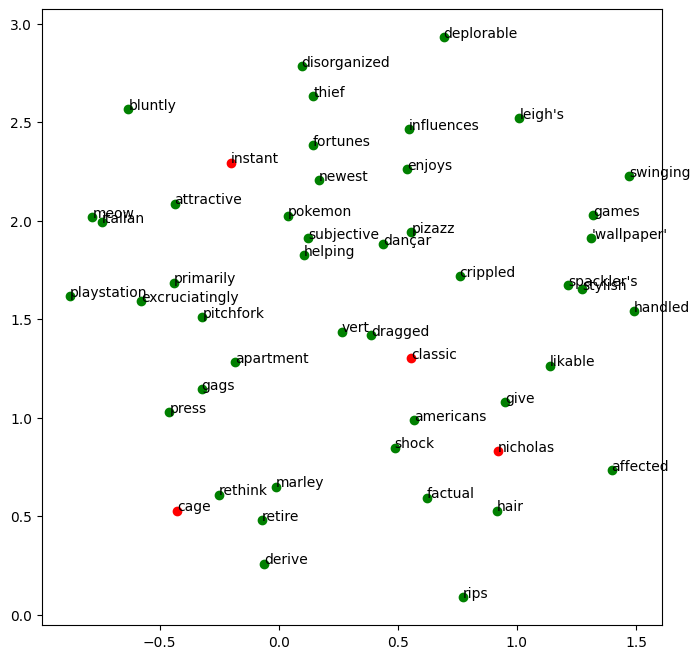

In [ ]:
# Get the embeddings
embeddings = embedding_model.target_embedding.weight.to('cpu').data.numpy()

# Graph the trained embedding again
tsne = TSNE()
tsne_embedding = tsne.fit_transform(embeddings[rw_indices])

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(random_words)):
    if random_words[i] in special_words:
        plt.scatter(tsne_embedding[i, 0], tsne_embedding[i, 1], color='red')
    else:
        plt.scatter(tsne_embedding[i, 0], tsne_embedding[i, 1], color='green')
    plt.annotate(random_words[i], (tsne_embedding[i, 0], tsne_embedding[i, 1]))

3. Changed the optimizer from Adam to SGD as well. As said, the training time was same with SGD. There are change in similarity values. (0.7664011835001016, 0.0004872345892374952), (0.07640067457331379, -0.06959697715885271).

In [ ]:
def train(classifier: torch.nn.Module, window_size: int = 3, num_neg_samples: int = 5,
          n_epoch: int = 10, batch_size: int = 512,
          report_every: int = 1000, learning_rate: int = 0.02) -> list[int]:
    """Define the training loop.

    Args:
        classifier: the embedding layer to train.
        window_size: the number of positive samples to pick.
        num_neg_samples: the number of negative smaples to pick per positive sample.
        n_epoch: the number of epochs to train for.
        batch_size: the size of individual batch.
        report_every: prints to the screen current loss after this many iterations.
        learning_rate: rate of which the learning is happening.

    Returns:
        A list of losses over the last epochs.
    """
    all_losses = []
    classifier.train()

    context_positive_batch, context_negative_batch, target_batch = get_batch(window_size=window_size, batch_size=batch_size, num_neg_samples=num_neg_samples)
    loss_fn = SkipGNGLoss()

    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate)
    for iter in range(0, n_epoch):
        running_loss = 0
        for i in range(len(context_positive_batch)):
            optimizer.zero_grad()


            mini_positive_tensor = torch.tensor(context_positive_batch[i])
            mini_negative_tensor = torch.tensor(context_negative_batch[i])
            mini_target_tensor = torch.tensor(target_batch[i])

            positive_tensor, negative_tensor, target_tensor = classifier(mini_positive_tensor, mini_negative_tensor, mini_target_tensor)

            loss = loss_fn(positive_tensor, negative_tensor, target_tensor)
            loss.backward()
            nn.utils.clip_grad_norm_(classifier.parameters(), 1) #

            optimizer.step()

            running_loss += loss.item()

            if i % report_every == 0:
                print(f'Current loss is {running_loss}')
        all_losses.append(running_loss / len(tokens))

    print(f'Epoch {iter}, Loss: {all_losses[-1]}')

    return all_losses

4. I was excited to check for datasets from hugging face. I learned different use cases will be having different preproessing techniques.
I tried with twitter evaluation where it performs sentiment analysis and explain label =1 (positive) ,label =0 (neutral) , label = -1(negative). Also, learned how we can work on datasets.


Positive aspects:
i) Data quality is good when processing and doing experimentation.
ii)Performance of the model is fine when running the word2vec.


Negative aspects:
i)The data contains lots of hashtags, emoji's, which requires more processing.
ii)Dataset is imbalanced due to many positive reviews.
iii)Able to notice unexpected similarity.


In [25]:
#Loaded the hugging face from dataset
from datasets import load_dataset

# Loading the TweetEval dataset from huggung face
twitter_dataset = load_dataset("tweet_eval", "sentiment")

# Printing a sample
print(twitter_dataset["train"][1])


README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"', 'label': 1}


Preprocessing techniques changes based on the dataset(use case) selected. For preprocessing techniques inorder to capture emotions, converting to lower case, removing special characters, hashtags is required.

In [27]:
# Preprocessing techniques
import re

def cleaning(text):
    text = text.lower()
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# Example
Example = twitter_dataset["train"][1]["text"]
print("Original_one:", Example)
print("Preprocessed_one:", cleaning(Example))


Original_one: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
Preprocessed_one: ben smith  smith concussion remains out of the lineup thursday curtis


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize tweets
tokenize = [cleaning(tweet["text"]).split() for tweet in twitter_dataset["train"]]

# Training Word2Vec model
word2vec_model = Word2Vec(sentences=tokenize, vector_size=100, window=5, min_count=2, workers=4)

# Saving the model
word2vec_model.save("tweet_word2vec.model")

# Checking for similar words
print(word2vec_model.wv.most_similar("happy"))


[('cake', 0.7147103548049927), ('dog', 0.6994593739509583), ('emo', 0.689663290977478), ('hot', 0.6879525780677795), ('kristian', 0.6842162013053894), ('chocolate', 0.6820783019065857), ('beyonces', 0.6808367967605591), ('blessed', 0.6769713163375854), ('jueves', 0.6724936366081238), ('hairampsock', 0.6645969748497009)]


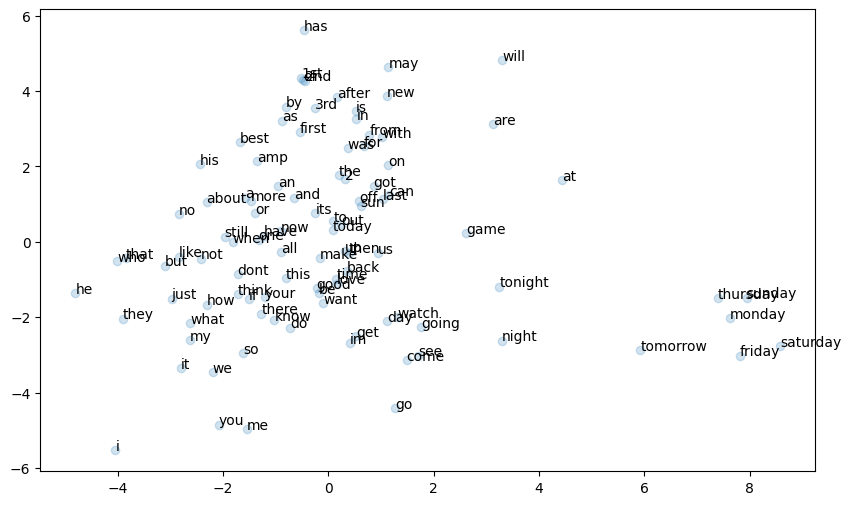

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get word vectors
words = list(word2vec_model.wv.index_to_key)
vector_word = word2vec_model.wv[words]

# Reducing dimensions
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vector_word[:100])

# Plotting the embeddings
plt.figure(figsize=(10, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.2)
for i, word in enumerate(words[:100]):
    plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))
plt.show()


REFERENCES/CITATIONS:
1)SLIDES FROM CLASS.
2)HUGGING FACE.
3)OPENAI.
